In [2]:
#pip install fitter

In [3]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy.stats import shapiro
from numpy.random import randn
import scipy.stats as stats
from __future__ import division
import scipy.stats
from datetime import datetime, timedelta
#import plotly.figure_factory as ff
import matplotlib, random
import re

In [4]:
df=pd.read_csv("station_db.csv")

/tmp/ipykernel_205/796669064.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("station_db.csv")


In [201]:
j=df["prec"]<0
df["prec"][j]=None

/tmp/ipykernel_35202/3016797823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prec"][j]=None


In [202]:
df["srad"] = df["srad"].replace("-", None, regex=True)
df["tmax"] = df["tmax"].replace("-", None, regex=True)
df["tmax"] = df["tmax"].replace(True, None, regex=True)
df["tmax"] = df["tmax"].replace("TRUE", None, regex=True)
df["tmax"] = df["tmax"].replace('   ',"", regex=True)
df["tmin"] = df["tmin"].replace("TRUE", None, regex=True)
df["tmin"] = df["tmin"].replace("-", None, regex=True)
df["wind"]= df["wind"].replace("-", None, regex=True)

In [203]:
df["srad"]=df["srad"].astype(float)
df["tmax"]=df["tmax"].astype(float)
df["tmin"]=df["tmin"].astype(float)
df["wind"]=df["wind"].astype(float)

In [204]:
dregion=pd.read_csv("coord_region.csv")

In [205]:
dregion=dregion[["name","country","Region"]]

In [206]:
# add Region in the data
df=df.merge(dregion,how='left', left_on='name', right_on='name')

In [207]:
#df.head(3)

In [770]:
def missing_evaluation(var,data1):
    L=[]
    data=data1[["name","date",var]]
    station_name=data["name"].unique()
    for i in range(len(station_name)):
        d=data[data["name"]==station_name[i]].reset_index()
        d=d.sort_values(by="date")
        df=d[d[var].isnull()].reset_index()
        L.append((len(df)/len(d))*100)
    dff=pd.DataFrame(L,columns=["prec"])
    dff["station name"]=station_name  
    return dff
# percentage of missing data for precipitation 
#df1=df[(df["Region"]=="South Region") ]
#L=missing_evaluation("prec",df1)

In [221]:
#filter east africa stations
#dEast=df[df["country"]=="Kenya"]
ds=['Butere','Migori','KAMIRITHU FANCY FARM','MALEWA FARMER COOP  SOC','N INANGOP FOREST STATION','NAIVASHA DO']


In [222]:
def remove_outlier(d,ds,var):
    L,L1=[],[]
    station_name = d["name"].unique()
    #LL=ds["name"].unique()
    LL=ds ## list of station we may want to remove the outlier
    dd=pd.DataFrame([],columns=d.columns)
    for station in station_name:
            df1=d[d["name"]==station]
            if station in LL :
                df1=df1.reset_index(drop=True)
                q1, q3 = np.percentile(df1[var], [25, 75])
                iqr,threshold = q3 - q1, 1.5
                outlier_indices = np.where((df1[var] < q1 - threshold * iqr) | (df1[var] > q3 + threshold * iqr))[0] 
                df1.drop(outlier_indices, axis=0, inplace=True)
                dd1=pd.concat([dd,df1],axis=0)
                dd=dd1
                L.append(len(outlier_indices))
                L1.append(station)
            else:
                q1, q3 = np.percentile(df1[var], [25, 75])
                iqr,threshold = q3 - q1, 1.5
                outlier_indices = np.where((df1[var] < q1 - threshold * iqr) | (df1[var] > q3 + threshold * iqr))[0] 
                dd1=pd.concat([dd,df1],axis=0)
                dd=dd1
                L.append(len(outlier_indices))
                L1.append(station)
    dff=pd.DataFrame(L1,columns=["name"])
    dff["N_Outlier"]=L
    return dd,dff

In [223]:
ddd=remove_outlier(df,ds,"prec") # East africa
# save the new dataset with outlier removed in kenya country
#ddd[0].to_csv("df_outlier_remove"+".csv",index=False)
#ddd[1].to_csv("Number_outlier"+".csv",index=False)          

/tmp/ipykernel_35202/2691808869.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dd1=pd.concat([dd,df1],axis=0)


In [195]:
ddd[0].to_csv("df_outlier_remove"+".csv",index=False)

In [5]:
# New data with outlier removed
df=pd.read_csv("df_outlier_remove.csv")

/tmp/ipykernel_205/677392635.py:2: DtypeWarning: Columns (7,9,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("df_outlier_remove.csv")


In [ ]:
# add Number of outlier per station in the data
#df=df.merge(pd.read_csv("Number_outlier.csv"),how='left', left_on='name', right_on='name')
#df.to_csv("df_outlier_remove"+".csv",index=False)

In [6]:
pd.read_csv("Number_outlier.csv")

,name,N_Outlier
0,BUK Kano_Nigeria,0
1,IAR ZARIA_Nigeria,342
2,Bengou Niger,88
3,Tarana Niger,86
4,Barto Niger,92
...,...,...
171,Man,0
172,Gikonko_1,0
173,Ntendezi,0
174,Ngoma,0


### Data distribution 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.055471,1954.308842,1987.337333,inf,0.735491,0.0
rayleigh,0.077223,20148.778887,20170.797881,inf,0.459461,0.0
beta,0.082954,23989.940101,24033.978089,inf,0.732642,0.0
norm,0.083618,22811.261577,22833.280571,inf,0.375798,0.0
lognorm,0.105059,2538.762438,2571.790929,inf,0.461136,0.0


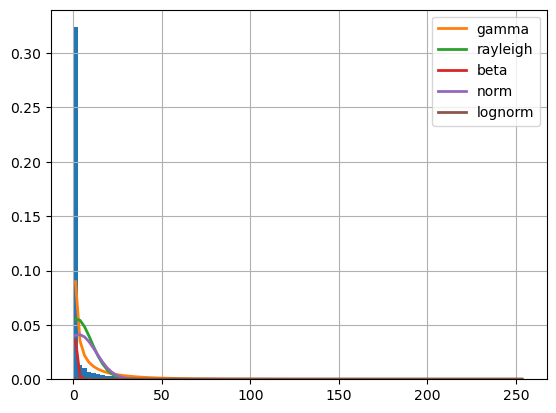

In [7]:
## West region
dW=df[df["Region"]=="West Region"]
dW=dW.sort_values(by="date")
dW=dW[dW["prec"].notnull()]
f = Fitter(dW["prec"],
           distributions=['gamma','lognorm', "beta","norm","rayleigh"])
f.fit()
f.summary()


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.017160,6720.894212,6767.387111,inf,0.633559,0.0
gamma,0.042756,2068.316807,2103.186481,inf,0.633559,0.0
rayleigh,0.069184,22827.698692,22850.945141,inf,0.385072,0.0
norm,0.076176,27085.542546,27108.788996,inf,0.339566,0.0
lognorm,0.102574,2432.208072,2467.077746,inf,0.410085,0.0


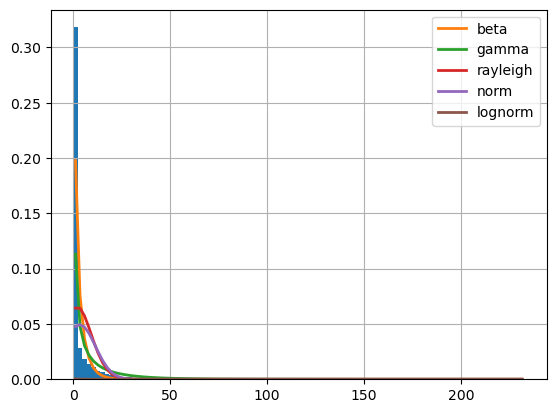

In [8]:
dW=df[(df["Region"]=="East Region") ]
dW=dW.sort_values(by="date")
dW=dW[dW["prec"].notnull()]
f = Fitter(dW["prec"],
           distributions=['gamma','lognorm', "beta","norm","rayleigh"])
f.fit()
f.summary()


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.094886,26462.246879,26503.012481,inf,0.761932,0.0
gamma,0.098241,1913.210421,1943.784623,inf,0.761929,0.0
rayleigh,0.125264,21905.915888,21926.298689,inf,0.473723,0.0
norm,0.136193,24447.689920,24468.072721,inf,0.388819,0.0
lognorm,0.171425,2530.952337,2561.526538,inf,0.473842,0.0


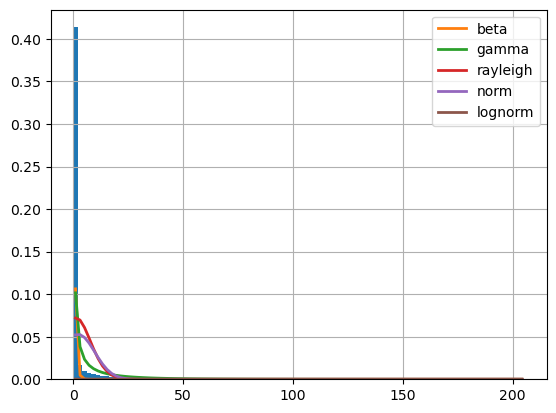

In [210]:
dW=df[df["Region"]=="South Region"]
dW=dW.sort_values(by="date")
dW=dW[dW["prec"].notnull()]
f = Fitter(dW["prec"],
           distributions=['gamma','lognorm', "beta","norm","rayleigh"])
f.fit()
f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
rayleigh,0.002383,230528.141685,230551.041059,inf,0.372122,0.0
norm,0.003791,295677.869142,295700.768516,inf,0.333902,0.0
beta,0.006697,52341.133931,52386.932678,inf,0.614899,0.0
gamma,0.010623,53139.659039,53174.008099,inf,0.614208,0.0
lognorm,0.011176,2670.837550,2705.186611,inf,0.400537,0.0


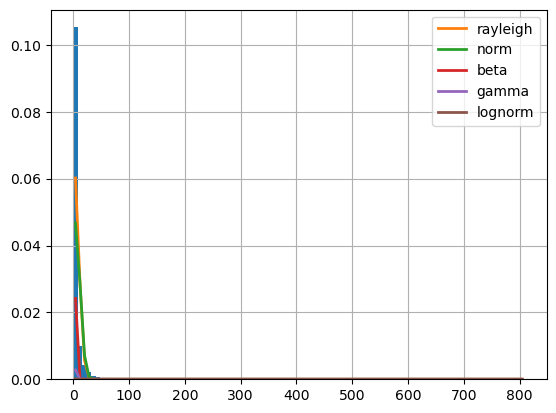

In [211]:
# check kenya country distribution
#dW=df[(df["country"]=="Kenya")& ((df["name"]!=cc[29])|(df["name"]!=cc[30])|(df["name"]!=cc[31])|(df["name"]!=cc[33])|(df["name"]!=cc[39])|(df["name"]!=cc[42])|(df["name"]!=cc[45])|(df["name"]!=cc[48])|(df["name"]!=cc[61])|(df["name"]!=cc[66])|(df["name"]!=cc[73]))]
dW=df[(df["country"]=="Kenya")]
dW=dW.sort_values(by="date")
dW=dW[dW["prec"].notnull()]
f = Fitter(dW["prec"],
           distributions=['gamma','lognorm', "beta","norm","rayleigh"])
f.fit()
f.summary()

In [20]:
#dW["prec"].unique()

In [212]:
#filter east africa stations
dEast=df[df["country"]=="Kenya"]

In [213]:
dEast=dEast[["date","name","prec"]]

In [214]:
cc=dEast["name"].unique()

In [219]:
# check the distribution station by staion 
dcoun=dEast[dEast["name"]==cc[1]]# cc[29],cc[30],cc[31],cc[33],cc[39],cc[42],cc[45],cc[48],cc[61],cc[66],cc[73]
            #'Kisii',KitaleMet','Bunyala','GATARE FOREST STATION','MWEIGA GATE','NGETHU WATER SUPPLY'
#'OLCHORO AGRI  OFFICE','SUBUKIA PYRETHRUM NURSERY','SURURU FOREST STATION'

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.036801,7110.804606,7142.436317,inf,0.571357,0.0
gamma,0.116081,1490.549041,1514.272824,inf,0.571357,0.0
rayleigh,0.200484,6301.421672,6317.237528,inf,0.345600,0.0
norm,0.210356,7095.926570,7111.742425,inf,0.318772,0.0
lognorm,0.250167,2280.044183,2303.767966,inf,0.378153,0.0


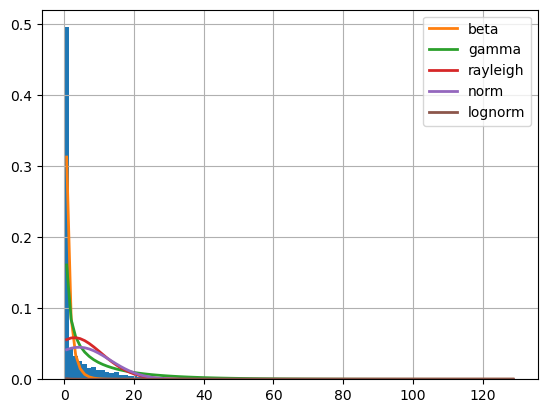

In [220]:

dW=dcoun.sort_values(by="date")
dW=dW[dW["prec"].notnull()]
f = Fitter(dW["prec"],
           distributions=['gamma','lognorm', "beta","norm","rayleigh"])
f.fit()
f.summary()

In [189]:
L=[cc[18],cc[23],cc[37],cc[46],cc[51],cc[61]]

In [190]:
L
#dcoun #["prec"].value_counts() 'Alupe', 'BungomaWS'

['Butere',
 'Migori',
 'KAMIRITHU FANCY FARM',
 'MALEWA FARMER COOP  SOC',
 'N INANGOP FOREST STATION',
 'NAIVASHA DO']

In [255]:
#L=['Eldoret','Kakamega','Kaimosi','Chemelil','Homabay','TinderetTea','Butere','ElgeyoForest','Nzoia','Rusinga','Migori','GilgilKwetu',
#'CHAMATA GATE','CHEBUSWA HILL','CULVERT CAMP','GILGIL KIKOPEY RANCH','KAMIRITHU FANCY FARM','N INANGOP FOREST STATION','NAIVASHA NANGA GERRI','NAIVASHA DO']

In [256]:
len(L)

24

In [ ]:
#**'CHEBUSWA HILL',**'CULVERT CAMP',**'CHEBUSWA HILL',*'Butere',*'DUNDORI FOREST STATION',*'GILGIL KIKOPEY RANCH'